In [136]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

In [482]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear_fft_tests.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
# MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\model_paper')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
# create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear


In [483]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear_fft_tests.pkl


In [484]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [485]:
u = torch.Tensor(dataset['y_train'])

In [486]:
f_coef = torch.fft.fft2(u)
F_ordered = f_coef.flatten(start_dim=1)
N = F_ordered.shape[1]

Et = torch.sum(torch.sum(torch.square(torch.abs(u)), dim=1), dim=1)
Ef = torch.sum(torch.sum(torch.square(torch.abs(f_coef)), dim=1), dim=1)/N

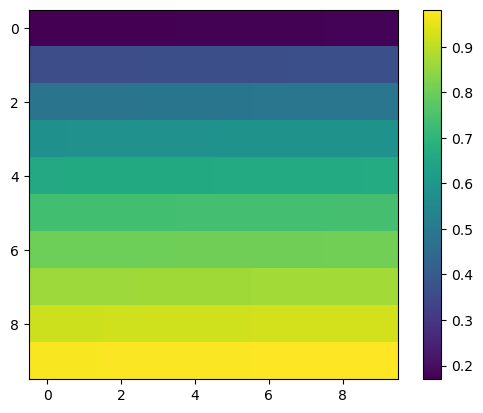

In [490]:
f_coef = torch.fft.fft2(u)

columna = f_coef[:, :, 0]
fila = f_coef[:, 0, :]

nuevo = torch.zeros_like(f_coef, dtype=torch.complex64)
nuevo[:, :, 0] = columna
nuevo[:, 0, :] = fila



# Aplicar la transformada inversa de Fourier
img_filtered = torch.fft.ifft2(nuevo)

# Tomar solo la parte real de la imagen filtrada
img_filtered = torch.real(img_filtered)

plt.imshow((img_filtered)[429])
plt.colorbar()
plt.show()


In [394]:
def fft_coeficients(data, n_modes):

    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros_like(fft_data_shifted, dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
            if 0 <= center_h + i < h and 0 <= center_w + j < w:
                mask[:, center_h + i, center_w + j] = fft_data_shifted[:, center_h + i, center_w + j]

    filtered_fft_data_shifted = fft_data_shifted * mask

    return filtered_fft_data_shifted

def fft_coeficients_to_tensor(fft_coeficients):







SyntaxError: incomplete input (1214056065.py, line 25)

In [225]:
mask = torch.zeros((100, 10, 10), dtype=torch.complex64)


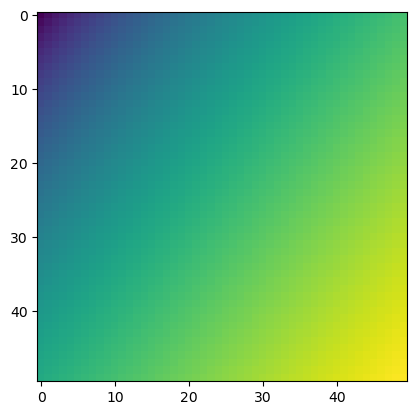

In [347]:
def relevant_modes_fft_coef(data, n_modes):
    
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros((N_data, n_modes + 1, n_modes + 1), dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
            mask[:, i + n_modes // 2, j + n_modes // 2] = fft_data_shifted[:, center_h + i, center_w + j]

    return mask


def reconstruct_relevant_modes(relevant_modes_fft_coef, shape):

    N_data, h, w = shape
    center_h, center_w = h // 2, w // 2
    n_modes = relevant_modes_fft_coef.shape[1] - 1

    reconstruction = torch.zeros((N_data, h, w), dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
             reconstruction[:, center_h + i, center_w + j] = relevant_modes_fft_coef[:, i + n_modes // 2, j + n_modes // 2]

    return torch.fft.ifft2(torch.fft.fftshift(reconstruction)).real



a = relevant_modes_fft_coef(u, 49)
u_recon = reconstruct_relevant_modes(relevant_modes_fft_coef(u, 49), u.shape)

plt.imshow(u_recon[0])

In [88]:
def error_images(data, n_modes):

    time_start = time.time()  # Use a different variable name for the start time

    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros_like(fft_data_shifted, dtype=torch.complex64)

    for data_i in range(N_data):
        for i in range(-n_modes//2, n_modes//2 + 1):
            for j in range(-n_modes//2, n_modes//2 + 1):
                if 0 <= center_h + i < h and 0 <= center_w + j < w:
                    mask[data_i, center_h + i, center_w + j] = fft_data_shifted[data_i, center_h + i, center_w + j]

    
    time_end = time.time()  # Use a different variable name for the end time

    print(time_end - time_start)  # Print the elapsed time



    # Create a mask and filter low-energetic modes
    mask = torch.zeros_like(fft_coef_shifted, dtype=torch.complex64)

    for img_idx in range(data.shape[0]):
        for idx in top_energy_indices[img_idx]:
            i, j = np.unravel_index(idx.item(), data.shape[1:])  
            mask[img_idx, i, j] = 1.0 

error_images(u, 5)

0.2520945072174072


In [ ]:
# Función para conservar solo las 5 frecuencias más energéticas
def keep_top_k_frequencies(image, k=10):
    # Convertir la imagen a tensor de PyTorch
    img_tensor = image
    
    # Aplicar la transformada de Fourier 2D
    
    
    # Desplazar el espectro de Fourier para centrar las frecuencias bajas
    

    # Calcular la magnitud (energía) de las frecuencias
    magnitude = torch.abs(fft_img_shifted)
    
    # Aplanar la magnitud y obtener los índices de las top-k frecuencias más energéticas
    flat_magnitude = magnitude.flatten()
    top_k_indices = torch.topk(flat_magnitude, k).indices

    # Crear una máscara con ceros
    mask = torch.zeros_like(fft_img_shifted, dtype=torch.complex64)
    
    # Usar los índices para mantener solo las 5 frecuencias más energéticas
    for idx in top_k_indices:
        # Convertir el índice plano en coordenadas 2D
        i, j = np.unravel_index(idx.item(), fft_img_shifted.shape)
        mask[i, j] = 1.0  # Dejar pasar solo estas frecuencias

    # Aplicar la máscara
    fft_filtered = fft_img_shifted * mask
    
    # Invertir el desplazamiento del espectro
    fft_filtered_shifted_back = 
    
    # Aplicar la transformada inversa de Fourier
    
    
    # Tomar solo la parte real de la imagen filtrada
    img_filtered = torch.real(img_filtered)

    return img_filtered

In [7]:
energy = []

for index in range(Et.shape[0]):
    energy.append(torch.sum(torch.sum(torch.square(torch.abs(F_ordered[index, :10]))))/N/Et[index])

minimo = np.min(energy)
maximo = np.max(energy)
primer_cuartil = np.percentile(energy, 25)
mediana = np.percentile(energy, 50)
tercer_cuartil = np.percentile(energy, 75)

# Imprimir los resultados
print(f"Máximo: {maximo:.2e}")
print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
print(f"Mediana (Q2): {mediana:.2e}")
print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
print(f"Mínimo: {minimo:.2e}\n")

minimo = np.min(energy)
indice_minimo = np.argmin(energy)

print(f"El valor mínimo es: {minimo}")
print(f"El índice del valor mínimo es: {indice_minimo}")

Máximo: 1.00e+00
Tercer cuartil (Q3): 9.94e-01
Mediana (Q2): 9.89e-01
Primer cuartil (Q1): 9.81e-01
Mínimo: 9.03e-01

El valor mínimo es: 0.9031832814216614
El índice del valor mínimo es: 429


tensor(0.0684)


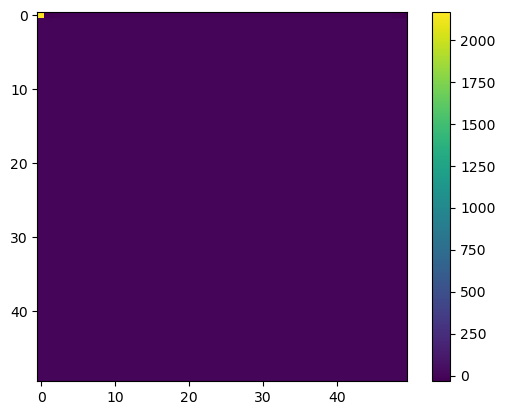

In [8]:
mask = np.zeros_like(F_ordered)
mask[:, :50] = 1

F_full = f_coef*mask.reshape(f_coef.shape)
u_reconstructed = torch.fft.ifft2(F_full).real

print(torch.sum(torch.abs(u - u_reconstructed))/torch.sum(torch.abs(u)))

plt.imshow(F_full[0].real)
plt.colorbar()

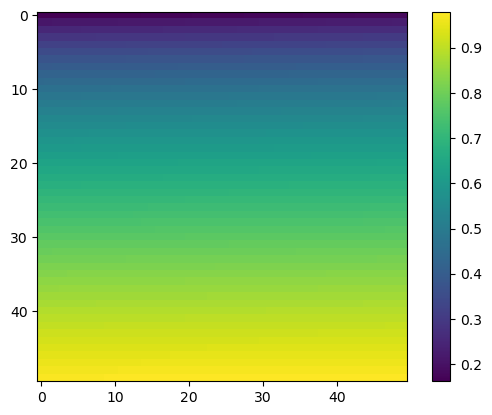

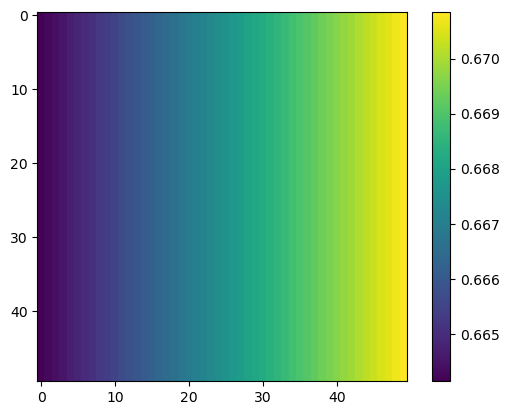

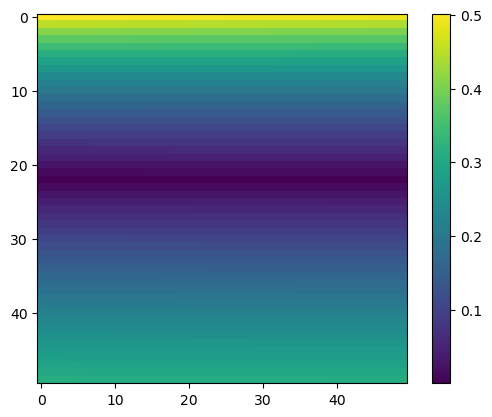

In [9]:
index = 429

plt.imshow(u[index])
plt.colorbar()
plt.show()

plt.imshow(u_reconstructed[index])
plt.colorbar()
plt.show()

plt.imshow(np.abs(u_reconstructed[index] - u[index]))
plt.colorbar()
plt.show()

In [12]:
def coef_to_tensor(coefs):

    filtered_coefficients_list = []

    for img_idx in range(coefs.shape[0]):
        non_zero_coefs = coefs[img_idx][coefs[img_idx] != 0]  # Filtrar coeficientes no nulos
        filtered_coefficients_list.append(non_zero_coefs)

    # Convertir la lista en un tensor de objetos PyTorch
    filtered_coefficients_tensor = torch.stack([torch.tensor(coefs) for coefs in filtered_coefficients_list])

    print(filtered_coefficients_tensor)

tensor([[1275, 1274, 1276, 1225, 1325],
        [1275, 1225, 1325, 1375, 1175],
        [1275, 1225, 1325, 1175, 1375],
        ...,
        [1275, 1225, 1325, 1274, 1276],
        [1275, 1225, 1325, 1175, 1375],
        [1275, 1276, 1274, 1273, 1277]])


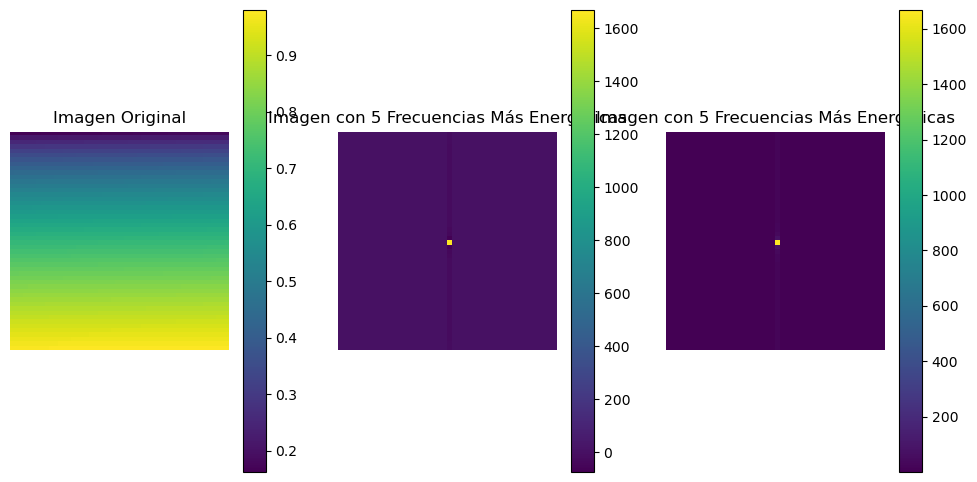

In [33]:
def decompose_data_FFT(data, n_components):

    # Forward FFT
    fft_coef = torch.fft.fft2(data)
    fft_coef_shifted = torch.fft.fftshift(fft_coef, dim=(-2, -1))
    
    # Obtain most energetic modes
    energy = torch.abs(fft_coef_shifted)
    flat_energy = energy.view(data.shape[0], -1) 
    top_energy_indices = torch.topk(flat_energy, n_components, dim=1).indices

    print(top_energy_indices[:, 0:5])

    # Create a mask and filter low-energetic modes
    mask = torch.zeros_like(fft_coef_shifted, dtype=torch.complex64)

    for img_idx in range(data.shape[0]):
        for idx in top_energy_indices[img_idx]:
            i, j = np.unravel_index(idx.item(), data.shape[1:])  
            mask[img_idx, i, j] = 1.0 

    fft_coef_filtered = fft_coef_shifted * mask

    return fft_coef_filtered

def compose_data_FFT(fft_coef_shifted_filtered):

    # Backward FFT
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_coef_shifted_filtered, dim=(-2, -1))
    data_filtered = torch.fft.ifft2(fft_filtered_shifted_back)
    data_filtered_real = torch.real(data_filtered)

    return data_filtered_real



index = 429
filtered = decompose_data_FFT(u, 50)[index].real
original = u[index]


plt.figure(figsize=(12, 6))
    
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title('Imagen Original')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(filtered)
plt.title('Imagen con 5 Frecuencias Más Energéticas')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(torch.abs(original - filtered))
plt.title('Imagen con 5 Frecuencias Más Energéticas')
plt.colorbar()
plt.axis('off')

plt.show()



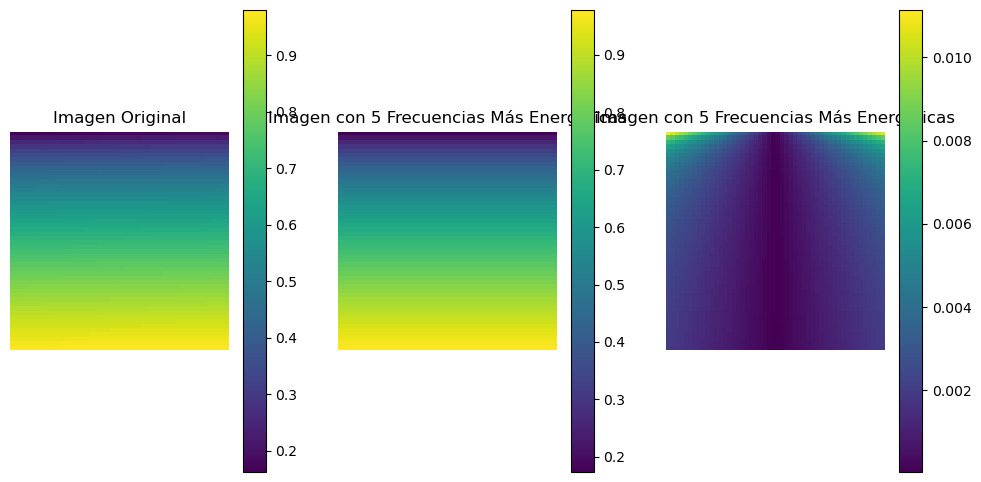

tensor(0.0026)


In [29]:
# Función para conservar solo las 5 frecuencias más energéticas
def keep_top_k_frequencies(image, k=10):
    # Convertir la imagen a tensor de PyTorch
    img_tensor = image
    
    # Aplicar la transformada de Fourier 2D
    fft_img = torch.fft.fft2(img_tensor)
    
    # Desplazar el espectro de Fourier para centrar las frecuencias bajas
    fft_img_shifted = torch.fft.fftshift(fft_img)

    # Calcular la magnitud (energía) de las frecuencias
    magnitude = torch.abs(fft_img_shifted)
    
    # Aplanar la magnitud y obtener los índices de las top-k frecuencias más energéticas
    flat_magnitude = magnitude.flatten()
    top_k_indices = torch.topk(flat_magnitude, k).indices

    # Crear una máscara con ceros
    mask = torch.zeros_like(fft_img_shifted, dtype=torch.complex64)
    
    # Usar los índices para mantener solo las 5 frecuencias más energéticas
    for idx in top_k_indices:
        # Convertir el índice plano en coordenadas 2D
        i, j = np.unravel_index(idx.item(), fft_img_shifted.shape)
        mask[i, j] = 1.0  # Dejar pasar solo estas frecuencias

    # Aplicar la máscara
    fft_filtered = fft_img_shifted * mask
    
    # Invertir el desplazamiento del espectro
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_filtered)
    
    # Aplicar la transformada inversa de Fourier
    img_filtered = torch.fft.ifft2(fft_filtered_shifted_back)
    
    # Tomar solo la parte real de la imagen filtrada
    img_filtered = torch.real(img_filtered)

    return img_filtered

# Función para mostrar la imagen original y filtrada
def plot_images(original, filtered):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Imagen Original')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(filtered)
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(original - filtered))
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.show()

    print(torch.sum(torch.abs(original - filtered))/torch.sum(original))


# Cargar la imagen
img_path = 'ruta/a/tu/imagen.jpg'
image = u[429]

# Conservar solo las 5 frecuencias más energéticas
filtered_image = keep_top_k_frequencies(image, k=50)

# Mostrar las imágeness
plot_images(image, filtered_image.numpy())